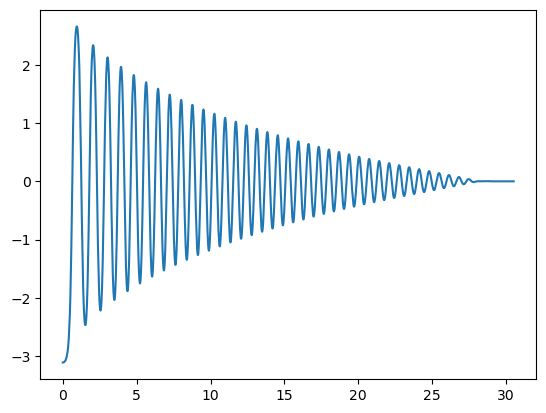

In [8]:
from numpy import zeros, size
from matplotlib.pyplot import plot
from ament_index_python.packages import get_package_share_directory
import os

oscillations_file = os.path.join(
    get_package_share_directory("furuta_pendulum_model"),
    "data",
    "oscillations.csv",
)

f = open(oscillations_file, "r")
lines = f.readlines()
numlines = size(lines)
f.close()

x_rosbag = zeros(numlines - 1)
t_rosbag = zeros(numlines - 1)

t_offset = float(lines[1].split(",")[0])
x_offset = -6.30218

for i in range(1, numlines):
    vals = lines[i].split(",")
    t_rosbag[i - 1] = float(vals[0]) - t_offset
    x_rosbag[i - 1] = float(vals[6]) - x_offset
    # x[i-1] = float(vals[7])

plot(t_rosbag, x_rosbag)


In [9]:
import yaml
import os
from ament_index_python.packages import get_package_share_directory

pendulum_params_file = os.path.join(
    get_package_share_directory("furuta_pendulum_description"),
    "config",
    "pendulum_parameters.yaml",
)

with open(pendulum_params_file, "r") as file:
    pendulum_params = yaml.safe_load(file)["/**"]["ros__parameters"]

g = 9.80665

m1 = pendulum_params["m1"]
m2 = pendulum_params["m2"]

l1 = pendulum_params["l1"]
l2 = pendulum_params["l2"]

L1 = pendulum_params["L1"]
L2 = pendulum_params["L2"]

J1 = pendulum_params["J1"]
J2 = pendulum_params["J2"]

b1 = pendulum_params["b1"]
b2 = pendulum_params["b2"]
# initially b2 wasn't correct, this is initial guess after initial optimization
b2 = 0.000014

J2_hat = J2 + m2 * l2 * l2
J0_hat = J1 + m1 * l1 * l1 + m2 * L1 * L1

tau1 = 0.0
tau2 = 0.0


In [10]:
import numpy as np


def F(y, t):
    # based on https://www.hindawi.com/journals/jcse/2011/528341/

    # theta3 = dtheta1
    # theta4 = dtheta2
    # dtheta3 = ddtheta1
    # dtheta4 = ddtheta2

    # theta1 = y[0]
    theta2 = y[1]
    theta3 = y[2]
    theta4 = y[3]

    vec11 = np.zeros((5, 1))
    vec11[0] = -J2_hat * b1
    vec11[1] = m2 * L1 * l2 * np.cos(theta2) * b2
    vec11[2] = -np.power(J2_hat, 2) * np.sin(2.0 * theta2)
    vec11[3] = -0.5 * J2_hat * m2 * L1 * l2 * np.cos(theta2) * np.sin(2.0 * theta2)
    vec11[4] = J2_hat * m2 * L1 * l2 * np.sin(theta2)

    vec21 = np.zeros((5, 1))
    vec21[0] = m2 * L1 * l2 * np.cos(theta2) * b1
    vec21[1] = -b2 * (J0_hat + J2_hat * np.power(np.sin(theta2), 2))
    vec21[2] = m2 * L1 * l2 * J2_hat * np.cos(theta2) * np.sin(2.0 * theta2)
    vec21[3] = (
        -0.5
        * np.sin(2.0 * theta2)
        * (J0_hat * J2_hat + np.power(J2_hat * np.sin(theta2), 2))
    )
    vec21[4] = -0.5 * np.power(m2 * L1 * l2, 2) * np.sin(2.0 * theta2)

    thetas_vec = np.zeros((5, 1))
    thetas_vec[0] = theta3
    thetas_vec[1] = theta4
    thetas_vec[2] = theta3 * theta4
    thetas_vec[3] = np.power(theta3, 2)
    thetas_vec[4] = np.power(theta4, 2)

    vec12 = np.zeros((3, 1))
    vec12[0] = J2_hat
    vec12[1] = -m2 * L1 * l2 * np.cos(theta2)
    vec12[2] = 0.5 * np.power(m2 * l2, 2) * L1 * np.sin(2.0 * theta2)

    vec22 = np.zeros((3, 1))
    vec22[0] = -m2 * L1 * l2 * np.cos(theta2)
    vec22[1] = J0_hat + J2_hat * np.power(np.sin(theta2), 2)
    vec22[2] = (
        -m2 * l2 * np.sin(theta2) * (J0_hat + J2_hat * np.power(np.sin(theta2), 2))
    )

    taus_g_vec = np.zeros((3, 1))
    taus_g_vec[0] = tau1
    taus_g_vec[1] = tau2
    taus_g_vec[2] = g

    denominator = (
        J0_hat * J2_hat
        + np.power(J2_hat * np.sin(theta2), 2)
        - np.power(m2 * L1 * l2 * np.cos(theta2), 2)
    )

    numerator1 = (vec11.T @ thetas_vec + vec12.T @ taus_g_vec)[0]
    numerator2 = (vec21.T @ thetas_vec + vec22.T @ taus_g_vec)[0]

    dy = np.zeros(4)
    dy[0] = theta3
    dy[1] = theta4
    dy[2] = numerator1 / denominator
    dy[3] = numerator2 / denominator

    return dy


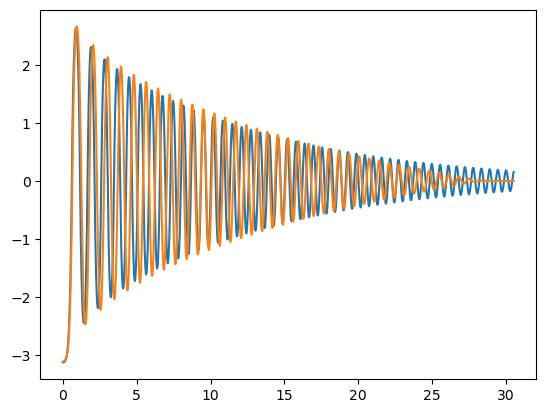

In [11]:
from scipy.integrate import odeint

# t = np.arange(0.0, 30, 1e-3)
s = odeint(F, y0=[0, -3.13, 0, 0], t=t_rosbag)
plot(t_rosbag, [x[1] for x in s])
plot(t_rosbag, x_rosbag)


# Optimization

In [12]:
class F_opt:
    def __init__(self, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2):
        self.m1 = m1
        self.m2 = m2
        self.l1 = l1
        self.l2 = l2
        self.L1 = L1
        self.L2 = L2
        self.J1 = J1
        self.J2 = J2
        self.b1 = b1
        self.b2 = b2
        self.J2_hat = J2 + m2 * l2 * l2
        self.J0_hat = J1 + m1 * l1 * l1 + m2 * L1 * L1

    def __call__(self, y, t):
        # based on https://www.hindawi.com/journals/jcse/2011/528341/

        # theta3 = dtheta1
        # theta4 = dtheta2
        # dtheta3 = ddtheta1
        # dtheta4 = ddtheta2

        # theta1 = y[0]
        theta2 = y[1]
        theta3 = y[2]
        theta4 = y[3]

        vec11 = np.zeros((5, 1))
        vec11[0] = -self.J2_hat * self.b1
        vec11[1] = self.m2 * self.L1 * self.l2 * np.cos(theta2) * self.b2
        vec11[2] = -np.power(self.J2_hat, 2) * np.sin(2.0 * theta2)
        vec11[3] = (
            -0.5
            * self.J2_hat
            * self.m2
            * self.L1
            * self.l2
            * np.cos(theta2)
            * np.sin(2.0 * theta2)
        )
        vec11[4] = self.J2_hat * self.m2 * self.L1 * self.l2 * np.sin(theta2)

        vec21 = np.zeros((5, 1))
        vec21[0] = self.m2 * self.L1 * self.l2 * np.cos(theta2) * self.b1
        vec21[1] = -self.b2 * (self.J0_hat + self.J2_hat * np.power(np.sin(theta2), 2))
        vec21[2] = (
            self.m2
            * self.L1
            * self.l2
            * self.J2_hat
            * np.cos(theta2)
            * np.sin(2.0 * theta2)
        )
        vec21[3] = (
            -0.5
            * np.sin(2.0 * theta2)
            * (self.J0_hat * self.J2_hat + np.power(self.J2_hat * np.sin(theta2), 2))
        )
        vec21[4] = (
            -0.5 * np.power(self.m2 * self.L1 * self.l2, 2) * np.sin(2.0 * theta2)
        )

        thetas_vec = np.zeros((5, 1))
        thetas_vec[0] = theta3
        thetas_vec[1] = theta4
        thetas_vec[2] = theta3 * theta4
        thetas_vec[3] = np.power(theta3, 2)
        thetas_vec[4] = np.power(theta4, 2)

        vec12 = np.zeros((3, 1))
        vec12[0] = self.J2_hat
        vec12[1] = -self.m2 * self.L1 * self.l2 * np.cos(theta2)
        vec12[2] = 0.5 * np.power(self.m2 * self.l2, 2) * self.L1 * np.sin(2.0 * theta2)

        vec22 = np.zeros((3, 1))
        vec22[0] = -self.m2 * self.L1 * self.l2 * np.cos(theta2)
        vec22[1] = self.J0_hat + self.J2_hat * np.power(np.sin(theta2), 2)
        vec22[2] = (
            -self.m2
            * self.l2
            * np.sin(theta2)
            * (self.J0_hat + self.J2_hat * np.power(np.sin(theta2), 2))
        )

        taus_g_vec = np.zeros((3, 1))
        taus_g_vec[0] = tau1
        taus_g_vec[1] = tau2
        taus_g_vec[2] = g

        denominator = (
            self.J0_hat * self.J2_hat
            + np.power(self.J2_hat * np.sin(theta2), 2)
            - np.power(self.m2 * self.L1 * self.l2 * np.cos(theta2), 2)
        )

        numerator1 = (vec11.T @ thetas_vec + vec12.T @ taus_g_vec)[0]
        numerator2 = (vec21.T @ thetas_vec + vec22.T @ taus_g_vec)[0]

        dy = np.zeros(4)
        dy[0] = theta3
        dy[1] = theta4
        dy[2] = numerator1 / denominator
        dy[3] = numerator2 / denominator

        return dy


def create_trajectory(t, m1, m2, l1, l2, L1, L2, J1, J2, b1, b2):
    f_opt = F_opt(m1, m2, l1, l2, L1, L2, J1, J2, b1, b2)
    s = odeint(f_opt, y0=[0, -3.13, 0, 0], t=t)
    return [x[1] for x in s]


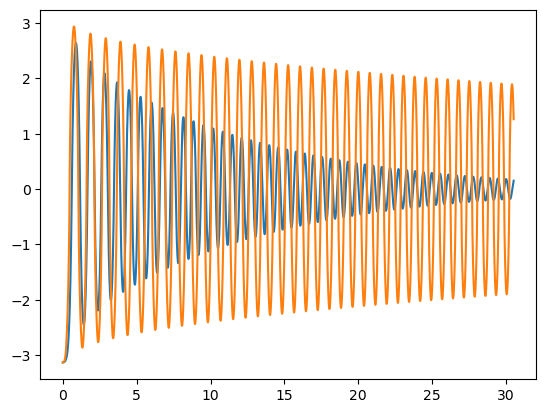

In [13]:
plot(t_rosbag, create_trajectory(t_rosbag, *[m1, m2, l1, l2, L1, L2, J1, J2, b1, b2]))
plot(
    t_rosbag,
    create_trajectory(t_rosbag, *[m1 + 0.1, m2 + 0.1, l1, l2, L1, L2, J1, J2, b1, b2]),
)


In [14]:
from scipy.optimize import curve_fit

# b1 can't be 0 - bounds won't be correct, so set it to really low value
b1 = 0.0000000001

min_scale = 0.5
max_scale = 1.5
min_bounds = [
    min_scale * m1,
    min_scale * m2,
    min_scale * l1,
    min_scale * l2,
    min_scale * L1,
    min_scale * L2,
    min_scale * J1,
    min_scale * J2,
    min_scale * b1,
    min_scale * b2,
]
max_bounds = [
    max_scale * m1,
    max_scale * m2,
    max_scale * l1,
    max_scale * l2,
    max_scale * L1,
    max_scale * L2,
    max_scale * J1,
    max_scale * J2,
    max_scale * b1,
    max_scale * b2,
]

initial_guess = [m1, m2, l1, l2, L1, L2, J1, J2, b1, b2]

opt_params, _ = curve_fit(
    create_trajectory,
    t_rosbag,
    x_rosbag,
    p0=initial_guess,
    bounds=(min_bounds, max_bounds),
)


<BarContainer object of 10 artists>

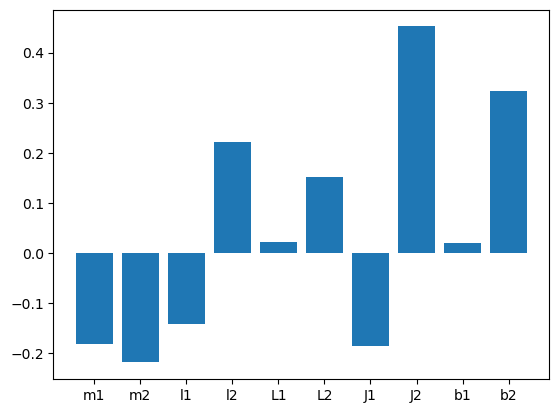

In [15]:
from matplotlib.pyplot import bar

bar(
    ["m1", "m2", "l1", "l2", "L1", "L2", "J1", "J2", "b1", "b2"],
    (opt_params - initial_guess) / initial_guess,
)


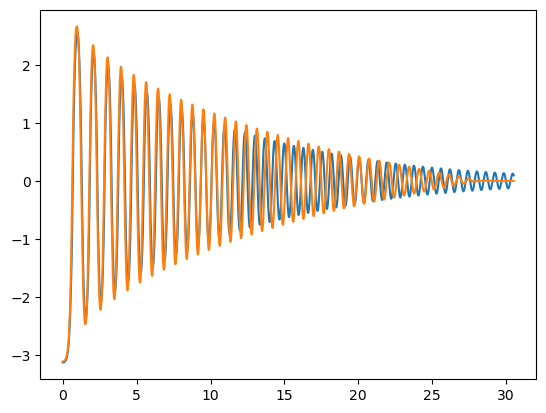

In [16]:
plot(t_rosbag, create_trajectory(t_rosbag, *opt_params))
plot(t_rosbag, x_rosbag)


In [17]:
print(f"m1: {opt_params[0]}")
print(f"m2: {opt_params[1]}")
print(f"l1: {opt_params[2]}")
print(f"l2: {opt_params[3]}")
print(f"L1: {opt_params[4]}")
print(f"L2: {opt_params[5]}")
print(f"J1: {opt_params[6]}")
print(f"J2: {opt_params[7]}")
print(f"b1: {opt_params[8]}")
print(f"b2: {opt_params[9]}")


m1: 0.03313030211340041
m2: 0.0076641500134336325
l1: 0.04646663938150794
l2: 0.11796072493398935
L1: 0.09568766250802578
L2: 0.1484960475053181
J1: 1.9593804030890658e-05
J2: 2.147958413502877e-05
b1: 1.0202540124912719e-10
b2: 1.8525811484196018e-05


In [ ]:
0.575/